# Project work, part 3 - Data quality

## General
- **<span style="color:red">If you push new updates to the main branch of your GitHub repository before the peer review and teacher feedback, things will get cluttered.</span>**
  - Create and use a new branch in the GitHub repository for new updates.  
  - When peer review and feedback are finished, merge your changes into the main branch.

- All project work in IND320 will result in personal hand-ins and online apps.  
  1. **A Jupyter Notebook run locally on your computer.**  
     - This will be your basic development and documentation platform.  
       - Must include a brief description of AI usage.  
       - Must include a 300–500-word log describing the compulsory work (including both Jupyter Notebook and Streamlit experience).  
       - Must include links to your public GitHub repository and Streamlit app (see below) for the compulsory work.  
     - Document headings should be clear and usable for navigation during development.  
     - All code blocks must include enough comments to be understandable and reproducible if someone inherits your project.  
     - All code blocks must be run before an export to PDF so the messages and plots are shown.  
     - In addition, add the `.ipynb` file to the GitHub repository where you have your Streamlit project.  

  2. **A Streamlit app running from `https://[yourproject].streamlit.app/`.**  
     - This is an online version of the project; accessing data has been uploaded to your MongoDB database, and data directly downloaded from open-meteo.com's API.  
     - The code, hosted at GitHub, must include relevant comments from the Jupyter Notebook and further comments regarding Streamlit usage.  

- There are four parts in the project work, building on each other and resulting in a final portfolio and app to be presented at the end of the semester.  

- Co-operation is applauded, and the use of AI tools is encouraged.

---

# Tasks

**Here are the links to Streamlit and Github:**
- Streamlit URL: https://ind320-rajvir-app-repo-mmma7ybzv7nuiev9exfsmq.streamlit.app/
- Github URL: https://github.com/rajern/ind320-rajvir

### Accounts and repositories
- Reuse your account, repository and Streamlit app from the previous part of the project work.  
- **Until peer review and feedback have been completed, [push to a temporary GitHub branch](https://)** for later merging.

### API
- Familiarise yourself with the API connection at [https://open-meteo.com/en/docs](https://open-meteo.com/en/docs)
  - Observe how you can select features and produce Python code.  
  - Be aware of multiple sub-sections that alter which type of data is selected.


## Jupyter Notebook

- Use Oslo, Kristiansand, Trondheim, Tromsø and Bergen as representatives for the five electricity price areas in Norway.  
  Find their geographical centre points in longitude and latitude.  
  Save price area codes, city names, longitude and latitude in a Pandas DataFrame.

- Use the open-meteo API to retrieve historical **reanalysis data using the ERA5 model** for a single location as follows:
  - Create a function for the API download task that takes a pair of longitude and latitude values, plus a year as input,  
    and downloads the same weather properties as were used in the CSV file in part 1 of the project work.  
  - Apply the function to download data for Bergen for the year 2019.

In [6]:
import pandas as pd

# Define locations for the five electricity price areas in Norway in a list of dictionaries
locations = [
    {"PriceArea": "NO1", "City": "Oslo",        "lat": 59.9139, "lon": 10.7522},
    {"PriceArea": "NO2", "City": "Kristiansand","lat": 58.1467, "lon": 7.9956},
    {"PriceArea": "NO3", "City": "Trondheim",   "lat": 63.4305, "lon": 10.3951},
    {"PriceArea": "NO4", "City": "Tromsø",      "lat": 69.6492, "lon": 18.9560},
    {"PriceArea": "NO5", "City": "Bergen",      "lat": 60.39299,"lon": 5.32415},
]
# Create and show dataframe
locations_df = pd.DataFrame(locations)
locations_df

,PriceArea,City,lat,lon
0,NO1,Oslo,59.91390,10.75220
1,NO2,Kristiansand,58.14670,7.99560
2,NO3,Trondheim,63.43050,10.39510
3,NO4,Tromsø,69.64920,18.95600
4,NO5,Bergen,60.39299,5.32415


In [ ]:
import pandas as pd
import openmeteo_requests

client = openmeteo_requests.Client()

def download_weather(lat, lon, year=2019):
    """
    Download hourly weather data for a single location and year
    using the Open-Meteo ERA5 archive API.
    Returns a pandas DataFrame with datetime and selected variables.
    """

    url = "https://archive-api.open-meteo.com/v1/archive"

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": [
            "temperature_2m",
            "precipitation",
            "wind_speed_10m",
            "wind_direction_10m",
            "wind_gusts_10m",
        ],
        "timezone": "auto",
        "models": "era5",
        "windspeed_unit": "ms",
    }

    resp = client.weather_api(url, params=params)[0]
    hourly = resp.Hourly()

    # Build proper datetime index from start, end and interval (seconds since epoch)
    times = pd.date_range(
        start=pd.to_datetime(hourly.Time(),    unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(),   unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
    )

    # Directly build DataFrame from API variables – uten masse mellomvariabler
    df = pd.DataFrame({
        "date": times,
        "temperature_2m":  hourly.Variables(0).ValuesAsNumpy(),
        "precipitation":   hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed_10m":  hourly.Variables(2).ValuesAsNumpy(),
        "wind_direction_10m": hourly.Variables(3).ValuesAsNumpy(),
        "wind_gusts_10m":  hourly.Variables(4).ValuesAsNumpy(),
    })

    return df


In [8]:
# Download Bergen weather data
lat = locations_df.loc[locations_df.City == "Bergen", "lat"].iloc[0]
lon = locations_df.loc[locations_df.City == "Bergen", "lon"].iloc[0]

bergen_weather = download_weather(lat, lon, year=2019)
bergen_weather

ValueError: All arrays must be of the same length

### Outliers and anomalies
- Plot the temperature as a function of time.
  - Perform a high-pass filtering of the temperature using **Direct Cosine Transfer (DCT)** to create seasonally adjusted temperature variations (SATV).
  - Add curves to the plot indicating **Statistical Process Control (SPC)** boundaries between inliers and outliers  
    based on the SATV according to robust statistics estimated from the whole year.  
    Colour outliers with a contrasting colour.  
    Do not plot SATV values; only use them to find boundaries and outliers.
  - Let the frequency cut-off for the DCT and the number of standard deviations be parameters with sensible defaults.
  - Wrap this in a function that returns the plot and relevant summaries of the outliers, and test the function.

- Plot the precipitation as a function of time.
  - Indicate anomalies according to the **Local Outlier Factor (LOF)** method.
  - Let the proportion of outliers be a parameter defaulting to 1%.
  - Wrap this in a function that returns the plot and relevant summaries of the outliers, and test the function.

In [28]:
# Function for plotting temperature and relevant summaries of outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import dct, idct


def plot_temperature_with_spc(
    df: pd.DataFrame,
    time_col="date",
    temp_col="temperature_2m",
    trend_keep_fraction=0.02,  # how much of the lowest DCT frequencies to keep for trend
    sigma_threshold=3.0        # sigma threshold for SPC limits
):
    # Ensure chronological order and extract arrays
    df = df.sort_values(time_col).reset_index(drop=True)
    timestamps = pd.to_datetime(df[time_col])
    temp = df[temp_col].to_numpy(dtype=float)

    # Simple NaN handling: interpolate missing values
    if np.isnan(temp).any():
        temp = pd.Series(temp).interpolate(limit_direction="both").to_numpy()

    n_samples = len(temp)

    # --------- DCT: separate low-frequency (trend) and high-frequency (variations) ----------
    coeffs = dct(temp, type=2, norm="ortho")

    # Number of lowest frequencies to keep for the smooth seasonal trend
    keep = max(1, int(trend_keep_fraction * n_samples))

    trend_coeffs = np.zeros_like(coeffs)
    trend_coeffs[:keep] = coeffs[:keep]
    seasonal_trend = idct(trend_coeffs, type=2, norm="ortho")

    # Seasonally Adjusted Temperature Variations (SATV)
    satv = temp - seasonal_trend

    # --------- Robust SPC statistics on SATV ----------
    satv_center = np.median(satv)
    satv_mad = np.median(np.abs(satv - satv_center))
    # Convert MAD to a normal-consistent sigma; fall back to std if MAD==0
    robust_sigma = 1.4826 * satv_mad if satv_mad > 0 else np.std(satv)

    satv_lower = satv_center - sigma_threshold * robust_sigma
    satv_upper = satv_center + sigma_threshold * robust_sigma

    # Map SPC limits back to temperature scale by adding the trend
    lower_limit = seasonal_trend + satv_lower
    upper_limit = seasonal_trend + satv_upper

    # Outliers are points where SATV is outside limits
    is_outlier = (satv < satv_lower) | (satv > satv_upper)

    # --------- Plot ----------
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(timestamps, temp, linewidth=0.9, label="Temperature")
    ax.plot(timestamps, lower_limit, linestyle="--", linewidth=0.9, label="SPC lower")
    ax.plot(timestamps, upper_limit, linestyle="--", linewidth=0.9, label="SPC upper")
    ax.scatter(timestamps[is_outlier], temp[is_outlier], s=12, color="red", label="Outliers")

    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    fig.tight_layout()

    summary = {
        "n_points": int(n_samples),
        "n_outliers": int(is_outlier.sum()),
        "outlier_fraction": float(is_outlier.mean()),
        "satv_center": float(satv_center),
        "robust_sigma": float(robust_sigma),
        "satv_lower": float(satv_lower),
        "satv_upper": float(satv_upper),
    }

    return fig, summary

{'n_points': 8760, 'n_outliers': 89, 'outlier_fraction': 0.010159817351598174, 'satv_center': -0.06231382886454612, 'robust_sigma': 2.465710251110906, 'satv_lower': -7.459444582197264, 'satv_upper': 7.334816924468171}


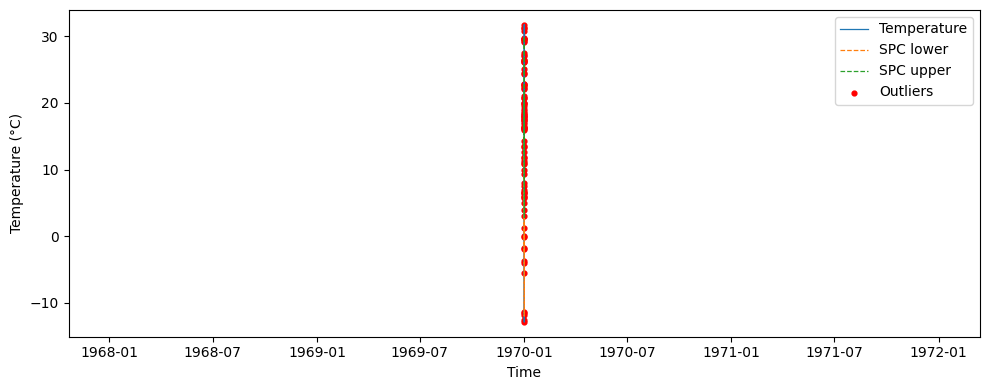

In [29]:
# Test temperature function on Bergen 2019 data
fig, stats = plot_temperature_with_spc(bergen_weather, time_col="date", temp_col="temperature_2m")
print(stats)

In [30]:
# Function for plotting precipitation and relevant summaries of outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor


def plot_precipitation_with_lof(
    df,
    time_col="date",
    precip_col="precipitation",
    outlier_fraction=0.01,  # desired share of outliers (e.g. 0.01 = 1%)
    n_neighbors=20          # neighbors used by LOF
):
    
    # Ensure chronological order and extract arrays
    df = df.sort_values(time_col).reset_index(drop=True)
    time = pd.to_datetime(df[time_col])
    precip = df[precip_col].to_numpy(dtype=float)

    # Simple NaN handling: interpolate missing values
    if np.isnan(precip).any():
        precip = pd.Series(precip).interpolate(limit_direction="both").to_numpy()

    n = len(precip)

    # LOF expects a 2D feature matrix
    X = precip.reshape(-1, 1)

    # Make sure n_neighbors is valid
    n_neighbors = max(5, min(n_neighbors, n - 1))

    # Fit Local Outlier Factor model
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=outlier_fraction,
        novelty=False
    )
    labels = lof.fit_predict(X)  # 1 = inlier, -1 = outlier

    is_outlier = labels == -1

    # Plot precipitation with outliers highlighted
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(time, precip, linewidth=0.9, label="Precipitation")
    ax.scatter(time[is_outlier], precip[is_outlier], s=12, color="red", label="Outliers")

    ax.set_xlabel("Time")
    ax.set_ylabel("Precipitation (mm)")
    ax.legend()
    fig.tight_layout()

    # Simple summary of outliers
    n_outliers = int(is_outlier.sum())
    summary = {
        "n_points": int(n),
        "n_outliers": n_outliers,
        "outlier_fraction_estimated": float(n_outliers / n),
        "precip_min_outlier": float(precip[is_outlier].min()) if n_outliers > 0 else None,
        "precip_max_outlier": float(precip[is_outlier].max()) if n_outliers > 0 else None,
    }

    return fig, summary


{'n_points': 8760, 'n_outliers': 72, 'outlier_fraction_estimated': 0.00821917808219178, 'precip_min_outlier': 2.299999952316284, 'precip_max_outlier': 9.5}


c:\Users\rajvi\OneDrive - Norwegian University of Life Sciences\z 1 semester\IND320\Assignments\ind320-rajvir-github-repo\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


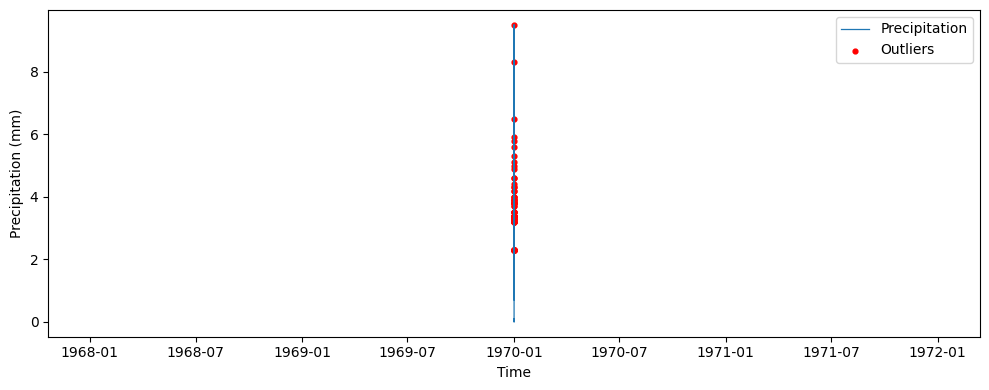

In [31]:
# Test precipitation function on Bergen 2019 data
fig, stats = plot_precipitation_with_lof(bergen_weather, time_col="date", precip_col="precipitation")
print(stats)

<u>(tried experimenting with different number of neighbours, but the warning does not seem to go away)</u>

**Retrieve elhub production data from MONGODB**

In [32]:
# Read MongoDB URI from secrets.toml
from pathlib import Path
import tomllib

secrets_path = Path("../.streamlit/secrets.toml")
uri = tomllib.load(open(secrets_path, "rb"))["MONGODB_URI"]

In [33]:
# Connect to MongoDB and select database and collection
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

client = MongoClient(uri, server_api=ServerApi('1'))
db = client["elhub2021"]
col = db["production_per_group_hour"]

In [34]:
# Load documents from MongoDB into a Pandas DataFrame
import pandas as pd

docs = list(col.find({}))          # Read all documents from the collection
df_elhub = pd.DataFrame(docs)      # Convert to DataFrame

# Drop MongoDB internal ID column if present
if "_id" in df_elhub.columns:
    df_elhub = df_elhub.drop(columns=["_id"])

print(df_elhub.head())
client.close()

  pricearea           starttime productiongroup  quantitykwh
0       NO5 2020-12-31 23:00:00         thermal     77742.00
1       NO5 2021-01-01 00:00:00           other         0.00
2       NO5 2021-01-01 01:00:00           solar         3.84
3       NO5 2021-01-01 02:00:00           hydro   3789087.20
4       NO5 2021-01-01 02:00:00           other         0.00


### Seasonal-Trend decomposition using LOESS (STL)
- Perform LOESS on the production data from *elhub* (downloaded in part 2 of the project) and plot its decomposition.
- Let the electricity price area, production group, period length, seasonal smoother, trend smoother and robust (true/false)  
  be parameters, and give each of them sensible defaults.
- Wrap this in a function that returns the plot, and test the function.

In [35]:
# Function for STL decomposition (LOESS) on Elhub production data
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

def plot_stl_elhub(
    df,
    area="NO3",
    group="hydro",
    period=24,
    seasonal=13,
    trend=365,
    robust=True,
    time_col="starttime",
    value_col="quantitykwh",
):
    # Filter for the chosen price area and production group
    sub = df[(df["pricearea"] == area) & (df["productiongroup"] == group)].copy()
    if sub.empty:
        raise ValueError("No data for this price area and production group.")

    # Make sure we have a sorted datetime index
    sub[time_col] = pd.to_datetime(sub[time_col])
    sub = sub.sort_values(time_col)
    series = sub.set_index(time_col)[value_col]

    # Force regular hourly frequency and fill small gaps
    series = series.asfreq("h")
    series = series.interpolate(limit_direction="both")

    # Run STL (Seasonal-Trend decomposition using LOESS)
    stl = STL(
        series,
        period=period,
        seasonal=seasonal,
        trend=trend,
        robust=robust,
    )
    result = stl.fit()

    # Standard decomposition plot from statsmodels
    fig = result.plot()
    fig.suptitle(f"STL decomposition – {area}, {group}", fontsize=10)
    fig.tight_layout()

    return fig, result

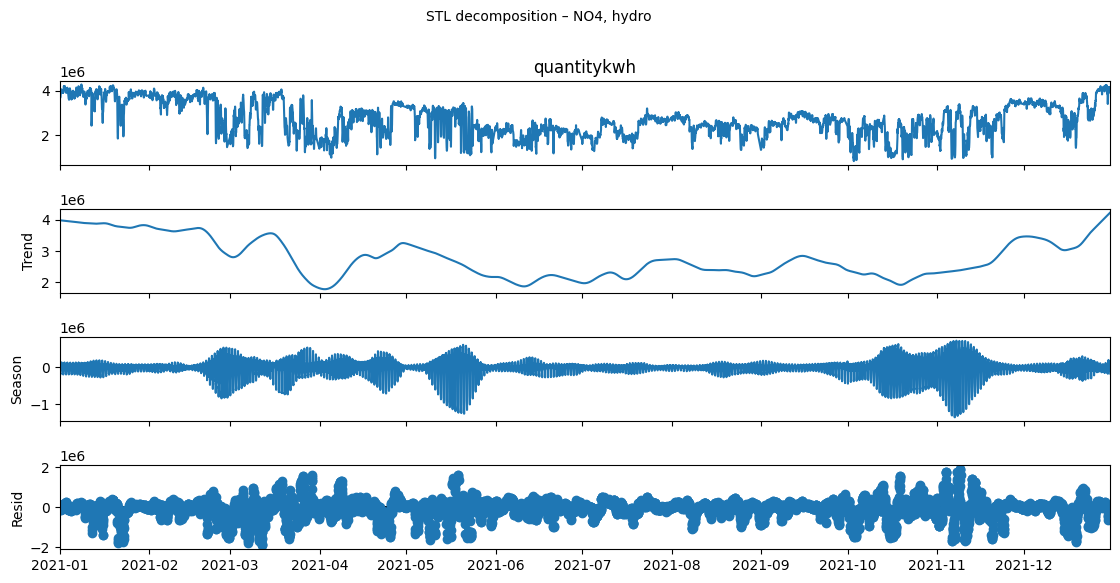

In [36]:
# Test the STL (LOESS) function on Elhub production data

# Choose a price area to inspect
area = "NO4"

# Call the STL helper function using the Elhub DataFrame from MongoDB
fig, result = plot_stl_elhub(
    df_elhub,   # Elhub data extracted from MongoDB above
    area=area,
    # The rest can stand as default values
)

# Show the decomposition plot
fig.set_size_inches(12, 6)  
plt.show()

### Spectrogram
- Create a spectrogram based on the production data from *elhub*.
- Let the electricity price area, production group, window length and window overlap be parameters, and give each of them sensible defaults.
- Wrap this in a function that returns the plot, and test the function.

In [37]:
# Function for creating a spectrogram from Elhub production data
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram_elhub(
    df,
    area="NO4",
    group="hydro",
    window_length=24*7,   # window length in hours
    window_overlap=0.5,   # fraction of overlap between windows
):

    # Filter data for selected price area and production group
    mask = (df["pricearea"] == area) & (df["productiongroup"] == group)
    df_sel = df.loc[mask].sort_values("starttime")

    # Extract production series as numpy array
    x = df_sel["quantitykwh"].to_numpy(dtype=float)

    # Convert window parameters to integers for spectrogram
    nperseg = int(window_length)
    noverlap = int(window_length * window_overlap)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 4))

    # Compute and plot the spectrogram 
    ax.specgram(x, NFFT=nperseg, Fs=1.0, noverlap=noverlap)

    # Add labels
    ax.set_title(f"Spectrogram – {area}, {group}")
    ax.set_xlabel("Time window")
    ax.set_ylabel("Frequency [cycles per hour]")

    return fig, ax


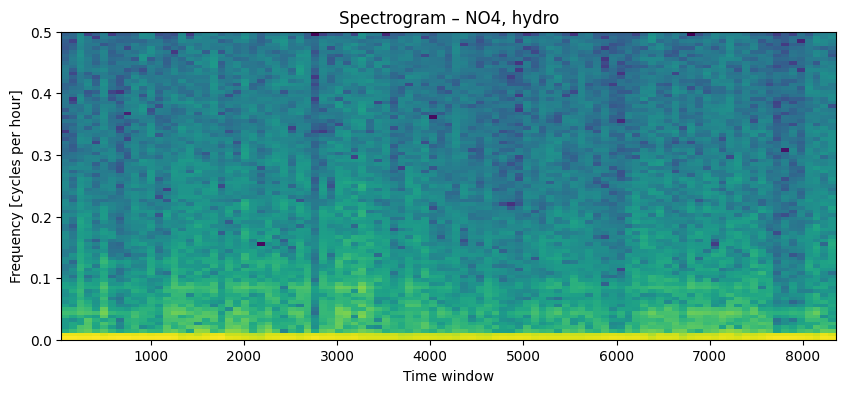

In [38]:
# Test the spectrogram function on Elhub data
fig_spec, ax_spec = plot_spectrogram_elhub(
    df_elhub,
    area="NO4",
    group="hydro",
    window_length=24*7,
    window_overlap=0.5,
)

plt.show()


## Streamlit app

- Update your Streamlit app from part 2 of the project according to the following points.
- Move page 4 (the one with the price area selector) in front of page 2, and add a new page between page 4 and page 3,  
  and a new page between page 3 and page 5, i.e.: Old order: 1, 2, 3, 4, 5. New order: 1, 4, new A, 2, 3, new B, 5

- Exchange the CSV import of meteorological data with the **open-meteo API import**.
- Let the choice of downloaded data depend on the selector that is now on page 2.  
  Let the chosen year be 2021.
- **Note:** For each of the new pages below, consider whether you can depend on the area selector on page 2 or need a local one.

- On page **"new A"**, use `st.tabs()` and fill:
- First tab: STL analysis  
- Second tab: Spectrogram  
Add necessary UI elements and plots to both.

- On page **"new B"**, use `st.tabs()` and fill:
- First tab: Outlier/SPC analysis  
- Second tab: Anomaly/LOF analysis  
Add necessary UI elements, plots and statistics to both.

### Work Log:

- Before even starting on the assignment I used quite some time just structuring the repository and fixing code from previous assignments. This laid the foundation for assignment 3, and eventually will for assignment 4 also. 

**Jupyter Notebook:**
- Just worked our way from the top to the bottom. 
- Started off with creating the pandas dataframe. Then we used the correct filters on the open meteo webpage and pasted the python code into jupyter notebook. We had to slightly adjust the code, because it didn't run properly. 
- Then we continued to outliers and anomalies part where we created two functions. One for plotting the temperature and one for precipitation. We also tested it on the data from Bergen API. 
- Next part was to retrieve the production data from MongoDB which was already put there in the previous assignment. So we just got the data from there. 
After that I went on to the LOESS (STL) function for the Elhub data. Here I first constructed a clean hourly time series per price area and production group (sorted index, .asfreq("h"), interpolation). Then I applied STL with parameters for period, seasonal, trend and robust, and used the built-in result.plot() to visualize level, trend and seasonal components. I tuned the parameters and checked decomposition quality for different groups.
- I then created the spectrogram code. This takes the same production series, converts it to a NumPy array and computes a spectrogram with a given window length and overlap using ax.specgram. I exposed the key parameters (window length and overlap) so they could be varied.
- As previously we also tested both of the functions, but this time on the elhub production data. 

**Streamlit app:**
- First just adding and reordering the new pages. 
- Then add a new cache function inside data_loader.py to get open meteo data from the api, rather than the csv file. 
- I then updated the code on page 2 (Production explorer) to keep using the Elhub data, but to act as the central selector for the whole app. The price area is now chosen via a radio button, and the selected value is stored in st.session_state["pricearea"]. All other pages read this shared value, so changing the price area on page 2 updates which data is used everywhere. I also did small adjustments to the grouping and plotting code to fit this structure.
- I also then went on and updated the code on page 4 and 5 also. They also had to use the new data from the api + changing plots based on selected price area. 
- Lastly I implemented page 3 and 6 (“New A” and “New B”). On page 3 I wired the STL and spectrogram functions from the notebook to the Elhub data, created two tabs (“STL” and “Spectrogram”), and added controls for price area (via session state), production group and key parameters (period, seasonal/trend smoothing, window length and overlap). On page 6 I did the same for the SPC and LOF functions: I loaded weather data via the API, created a date column to match the notebook functions and set up two tabs (“SPC – temperature” and “LOF – precipitation”) with sliders for trend fraction, sigma threshold, desired outlier fraction and number of neighbors. Both pages display the plots and summary statistics directly in Streamlit. 

### AI Usage:

**Used ChatGPT plus version for all the tasks below. Used both the GPT 5 thinking version and the GPT 5 regular one.** 

**API:**
- Gave the link of the open meteo webpage to GPT 5 and asked it to explain how the api and the webpage works. 

**Jupyter Notebook:**

API download:
- Used it to find the coordinates of each city. 
- Also gave the link to the open meteo webpage to give me instructions on what exact filters to choose to create the python code for extracting weather data from Bergen in 2019. 
- All of the original code was not fully necessary, so removed and fixed the code with AI such that it ran properly. 

Outliers and anomalies:
- Used it to understand the different terms + generate parts of the code. 
- Used it to decide sensible variables for DCT and SPC. 

Elhub production data:
- Decided together with AI the best approach to retrieve elhub data. Dercided that getting it from MongoDB was the best because there the data didn't need any preprocessing or call to API and was ready.

Seasonal trend decomposition and spectrogram:
- Used AI to understand what we're supposed to do, just like the previous part. Then I sparred back and forth with AI to generate code and debug when issued arose.
- Also used AI to generate large parts of the code. 
- Whenever I didn't understand or things in the code were wrong I iteratively worked on the code with the AI. 

**Streamlit app:**
- For the Streamlit app I used AI to propose a simple page structure, show how to use st.session_state to share the price area selection, and draft the code for the new “New A” and “New B” pages with st.tabs. I then simplified the generated code, adjusted naming and comments to my own style, and manually tested and fixed any remaining bugs in the app.

 
 